In [1]:
from dotenv import load_dotenv
import os
import getpass

load_dotenv()

True

In [2]:
if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

In [3]:
if "LANGSMITH_API_KEY" not in os.environ:
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter your LangSmith API key: ")
os.environ["LANGSMITH_TRACING"] = "true"

In [4]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="moonshotai/kimi-k2-instruct"
)

In [5]:
from langchain_core.tools import Tool
from langchain_experimental.utilities import PythonREPL

In [6]:
python_repl = PythonREPL()

In [7]:
from langchain_experimental.utilities import PythonREPL
import sys
from io import StringIO

class PersistentPythonREPLTool(PythonREPL):
    def __init__(self):
        super().__init__()
        self._globals = {}

    def run(self, command: str) -> str:
        # Capture stdout
        old_stdout = sys.stdout
        sys.stdout = captured_output = StringIO()
        
        try:
            # First try eval (single expression)
            result = eval(command, self._globals)
            output = captured_output.getvalue()
            if output:
                return output + str(result)
            return str(result)
        except SyntaxError:
            # If it's a statement block, use exec
            try:
                exec(command, self._globals)
                output = captured_output.getvalue()
                return output if output else "Executed successfully with no output."
            except Exception as e:
                output = captured_output.getvalue()
                return output + repr(e) if output else repr(e)
        except Exception as e:
            output = captured_output.getvalue()
            return output + repr(e) if output else repr(e)
        finally:
            # Restore stdout
            sys.stdout = old_stdout

In [8]:
repl_tool = Tool(
    name="python_repl",
    description="A Python shell. Use this to execute python commands. Input should be" \
                " a valid python command. If you want to see the output of a value, you " \
                "should print it out with `print(...)`.",
    func=python_repl.run,
)

In [9]:
if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API key:\n")

In [10]:
from langchain_tavily import TavilySearch

In [11]:
from langchain_core.tools import tool

@tool(name_or_callable="tavily_search", description="Use Tavily to search the web for current or recent events.")
def tavily_search(query: str) -> str:
    search = TavilySearch(  
        max_results=5,
        topic="general",
        )
    response = search.invoke({"query": query})
    # Return a summary of top result(s) — you could customize this
    results = response.get("results", [])
    if not results:
        return "No results found."
    return results[0].get("content", "No content available.")

In [12]:
def generate_hint(question: str) -> str:
    """Generate a helpful hint for a DSA problem without solving it.
    input: question (str): The DSA problem to generate a hint for.
    output: str: A helpful hint for the DSA problem."""
    
    return llm.invoke(f"Give a helpful hint for this DSA problem without solving it: {question}")


In [13]:
def generate_test_cases(problem_description: str) -> str:
    """Use this to generate test cases for DSA problems.
    input: problem_description - the DSA problem statement
    output: 3 test cases without solving the problem"""
    
    return llm.invoke(f"Create 3 test cases for this DSA problem without solving it: {problem_description}")


In [14]:
def bug_hint_tool(code: str) -> str:
    """Use this to analyze code for logic issues and provide a subtle hint.
    input: code - the code to analyze
    output: str - a subtle hint about potential logic issues in the code.
    """

    return llm.invoke(f"Analyze this code for logic issues and give a subtle hint: {code}")


In [15]:
tools = [repl_tool, tavily_search,generate_hint, generate_test_cases, bug_hint_tool]

In [16]:
llm_with_tools = llm.bind_tools(tools)

In [17]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage,SystemMessage,AnyMessage
from langgraph.graph import StateGraph, START

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


In [18]:
sys_msg = SystemMessage(content=(
    "You are a Socratic DSA mentor. Your primary goal is to guide users to a solution through questions and hints, not to provide the answer directly. "
    "Engage in a conversation. Ask clarifying questions to understand the user's thought process. "
    "You have access to the following tools:\n"
    "- `repl_tool`: To execute python code.\n"
    "- `tavily_search`: To search the web.\n"
    "- `generate_hint`: To provide hints for a problem.\n"
    "- `generate_test_cases`: To generate test cases for a problem.\n"
    "- `bug_hint_tool`: To find bugs in code and provide hints.\n"
    "Only provide the full code solution if the user explicitly asks for it or is completely stuck after several hints. "
    "Your role is to foster learning by encouraging the user to think for themselves."
))


In [19]:
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.graph import MessagesState

In [20]:
def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [21]:
graph = StateGraph(State)
graph.add_node("assistant", assistant)
graph.add_node("tools", ToolNode(tools))
graph.add_edge(START,"assistant")
graph.add_conditional_edges("assistant", tools_condition)
graph.add_edge("tools", "assistant")

In [22]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [23]:
app=graph.compile(checkpointer=memory)

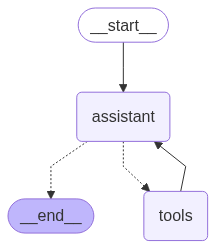

In [24]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [27]:
thread = {"configurable": {"thread_id": "123"}}

while True:
    # Get user input
    user_input = input("\nYou: ").strip()
    if user_input.lower() in {"exit", "quit", "cancel"}:
        print("Conversation ended.")
        break

    # Wrap input as a HumanMessage
    initial_input = {"messages": [HumanMessage(content=user_input)]}

    # Stream app output
    for event in app.stream(initial_input, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()

================================ Human Message =================================

can you help me with two sum problem
================================== Ai Message ==================================

Absolutely! Let’s step back to the 2Sum problem so you can solidify that foundation before returning to 3Sum.

A quick recap of the problem statement (to make sure we’re on the same page):

Given:
- An array `nums` of integers.
- A `target` integer.

Find any one pair `(i, j)` with `i ≠ j` such that `nums[i] + nums[j] == target`.  
Return either the indices or the values, depending on the variant you’re solving.

I’ll guide you through two classic approaches. First, though, let me ask:

1. Do you need to return the **indices** of the two numbers, or just the **values**?
2. May we assume each input has exactly one solution, or do we need to handle multiple/no-solution cases?
3. Should the solution have **O(n log n)** time (sorting + two pointers) or **O(n)** time (hash map)?

Pick the vari

Python REPL can execute arbitrary code. Use with caution.


================================== Ai Message ==================================
Tool Calls:
  python_repl (0)
 Call ID: 0
  Args:
    __arg1: def two_sum(nums, target):
    num_map = {}
    for i, num in enumerate(nums):
        complement = target - num
        if complement in num_map:
            return [num_map[complement], i]
        num_map[num] = i
    return []

# Test Suite
test_cases = [
    ([2, 7, 11, 15], 9),        # expected [0, 1]
    ([3, 2, 4], 6),           # expected [1, 2]
    ([3, 3], 6),              # expected [0, 1] (duplicates)
    ([-1, -2, -3, -4, -5], -8), # expected [2, 4] (negatives)
]

for nums, target in test_cases:
    result = two_sum(nums, target)
    print(f"Input: nums={nums}, target={target} -> Output: {result}")
================================= Tool Message =================================
Name: python_repl

Input: nums=[2, 7, 11, 15], target=9 -> Output: [0, 1]
Input: nums=[3, 2, 4], target=6 -> Output: [1, 2]
Input: nums=[3, 3], target=6 -> 

InternalServerError: Error code: 503 - {'error': {'message': 'moonshotai/kimi-k2-instruct is currently over capacity. Please try again and back off exponentially. Visit https://groqstatus.com/ to see if there is an active incident.', 'type': 'internal_server_error'}}